# Example: Quantum Integer Factorization

Identifying new methods for integer factorization plays an important role in modern information security. Shor’s algorithm is perhaps the most well-known method for integer factorization. An equally powerful model of quantum computing is the adiabatic quantum computing (AQC) model, which can also solve the integer factorization problem. In this example, we show how to convert an arbitrary integer factorization problem to an executable Ising model and tested it on the Dynex Neuromorphic Platform.

##  Factoring as a Constraint Satisfaction Problem

The complexity class for classical integer factoring is believed to be between P and NP-hard. Although research has yielded algorithms that perform faster than the intuitive trial division, including Fermat's algorithm, Pollard's two algorithms, and sieve algorithms, it's still an open question whether a classical algorithm exists that can factor in polynomial time. For quantum computing, Shor's algorithm runs in polynomial time (D-Wave quantum computers do not run this algorithm, nor does the Dynex Neuromorphic Platform yet).

This notebook solves factoring on the Dynex Neuromorphic Platform by formulating it as a constraint satisfaction problem. CSPs require that all a problem's variables be assigned values that result in the satisfying of all constraints. For factoring, the problem's constraints are that the two variables representing factors, a and b, be assigned only natural numbers and that their multiplication be equal to the factored number, P.

Among CSPs are hard problems well suited to solution on quantum computers. For example, the map-coloring problem is to color all regions of a map such that any two regions sharing a border have different colors. The job-shop scheduling problem is to schedule multiple jobs done on several machines with constraints on the machines' execution of tasks. You can apply the solution technique shown here to many CSPs.

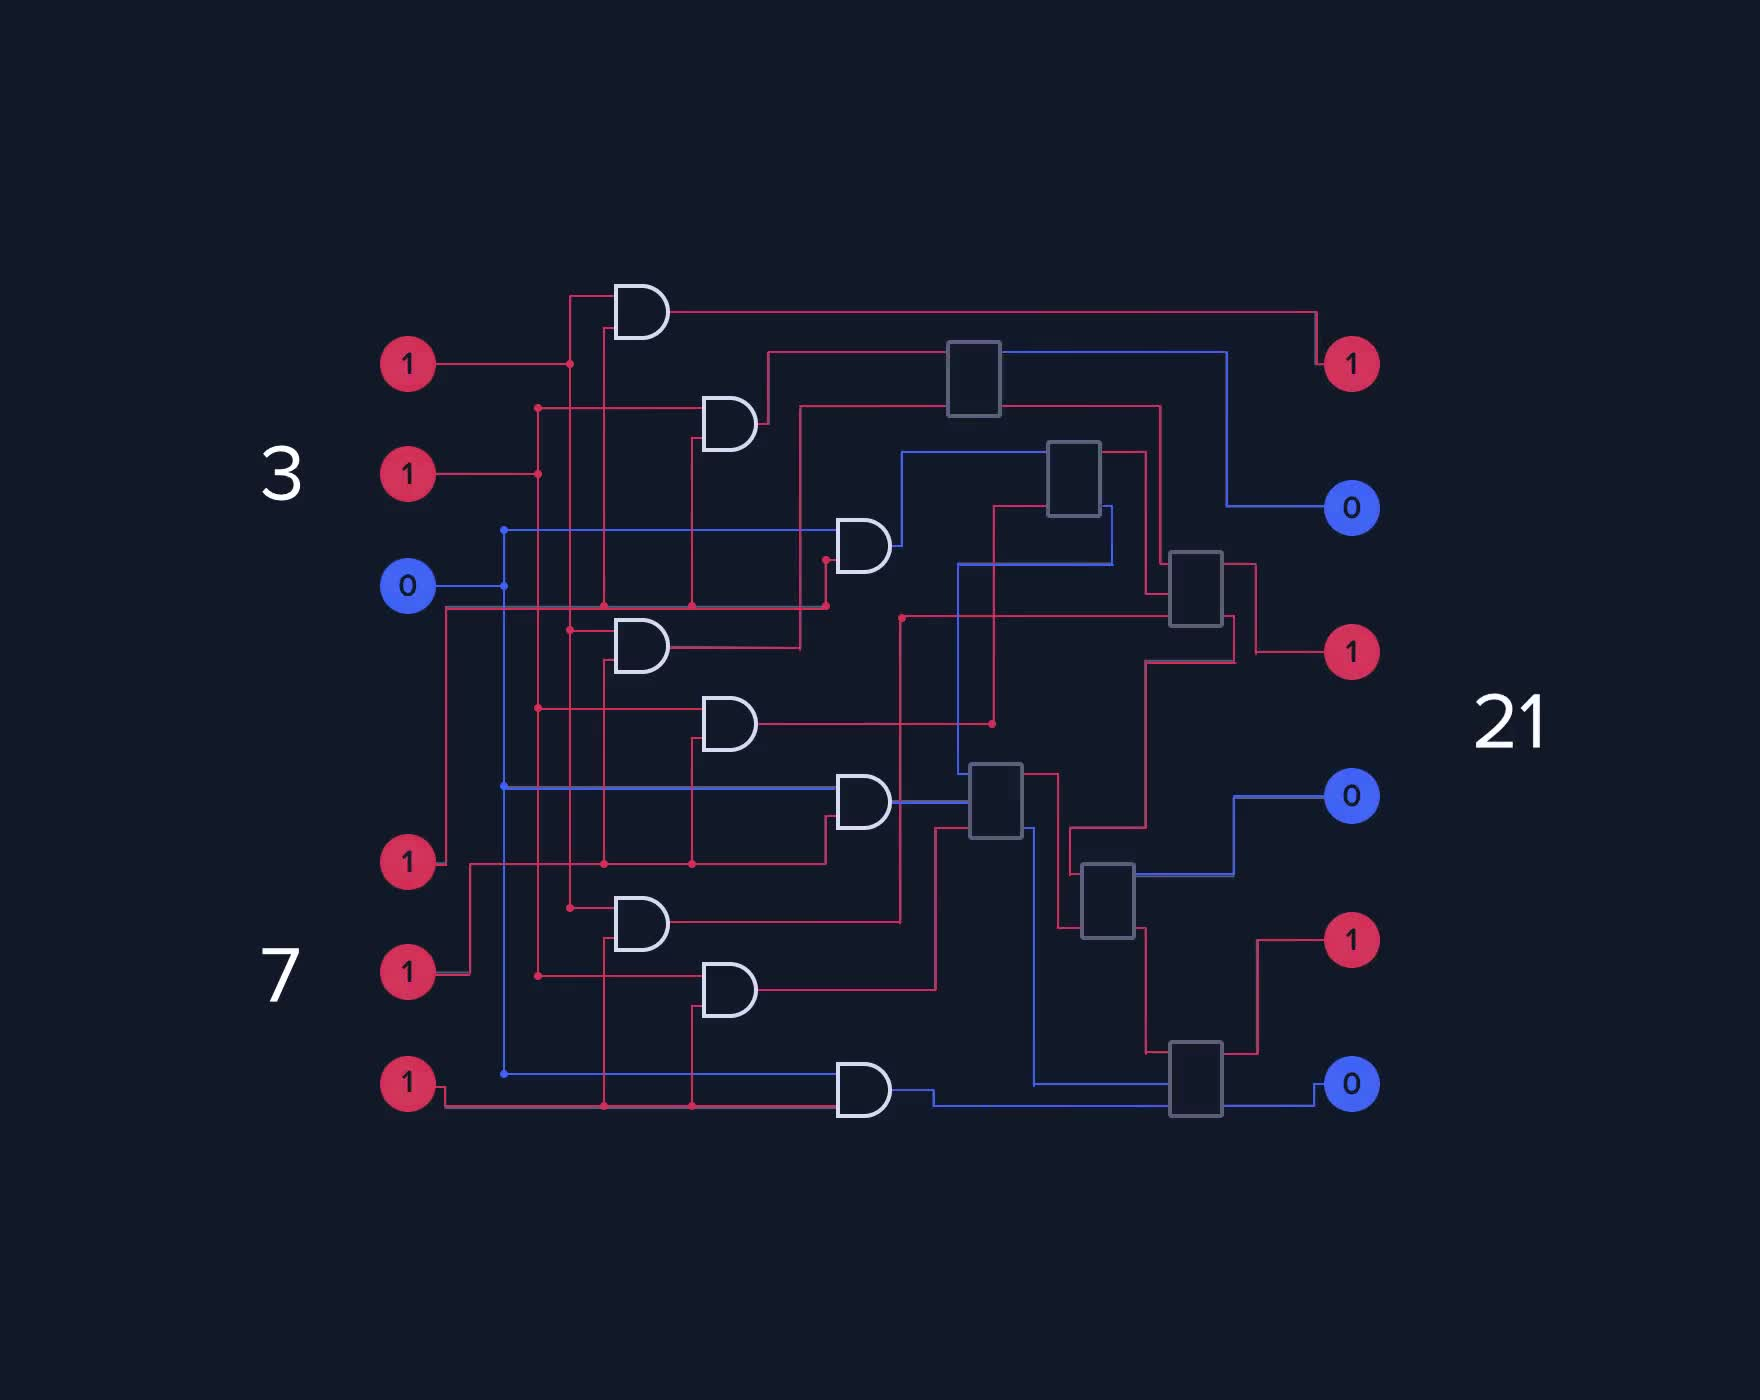

## Formulating the Problem for the Dynex Neuromorphic Platform 

How can you formulate the factoring problem in a way that a quantum / neuromorphic computer  can understand?

The Dynex platform solves binary quadratic models (BQM), the Ising model traditionally used in statistical mechanics and its computer-science equivalent, the quadratic unconstrained binary optimization (QUBO) problem. Given N variables x1,....,xn, where each variable xi can have binary values 0 or 1, the neuromorphic platform finds assignments of values that minimize the QUBO

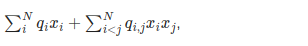

where qi and qi,j are configurable (linear and quadratic) coefficients. To formulate a problem for the Dynex platform is to program qi and qi,j so that assignments of x1,....,xn also represent solutions to the problem.

## Step 1: Express Factoring as Multiplication Circuit 

We start by expressing the problem with Boolean logic gates, in this case a multiplication circuit.

This example factors integer 196 which is represented as a 8-bit binary number. To express the factoring equation, 
, in Boolean logic, use a simple 4-bit multiplier (a circuit that takes two 4-bit binary numbers and outputs their 8-bit binary product).

Note: Binary multipliers are made with logic gates like the AND gate used above. Understanding the factoring example and its application to solving CSPs does not require an understanding of binary multiplication. 

We start by loading the Dynex SDK and the required libraries:

In [1]:
from itertools import product
import json
import random 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import dynex
import dimod
from dimod.generators import multiplication_circuit

Next we define the integer number we want to factor and convert it into its binary 8 bit representation:

In [3]:
P = 196 
bP = "{:8b}".format(P);    
print(P,' =  binary ',bP);

196  =  binary  11000100


## Step 2: Convert to a BQM 

Express the multiplication circuit as a BQM that provides the coefficients used to program the problem on a the Dynex platform.

In [4]:
bqm = multiplication_circuit(4);
print("BQM has {} variables".format(len(bqm.variables)));

BQM has 48 variables


The Dynex Neuromorphic Platform factors this integer by running a multiplication circuit in reverse. Below, fix the variables of the multiplication circuit's BQM to the binary digits of the factored number P (represented by binary variables P0, P1...P6). This modifies the BQM by removing the known variables and updating neighboring values accordingly.

In [5]:
p_vars = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']

# Convert P from decimal to binary
fixed_variables = dict(zip(reversed(p_vars), "{:08b}".format(P)))
fixed_variables = {var: int(x) for(var, x) in fixed_variables.items()}
print('Fixing target variables:',fixed_variables,P)

# Fix product variables
for var, value in fixed_variables.items():
    bqm.fix_variable(var, value)
    
print("BQM has {} non-fixed variables".format(len(bqm.variables)))

Fixing target variables: {'p7': 1, 'p6': 1, 'p5': 0, 'p4': 0, 'p3': 0, 'p2': 1, 'p1': 0, 'p0': 0} 196
BQM has 40 non-fixed variables


## Step 3: Submit to the Dynex Neuromorphic Platform 

Lastly, solve the BQM by finding variable assignments that produce its lowest values. Here we use the Dynex Neuromorphic Platform:

In [36]:
dnxmodel = dynex.BQM(bqm, logging=True);
dnxsampler = dynex.DynexSampler(dnxmodel, logging=True, mainnet=False);

[DYNEX] MODEL CONVERTED TO QUBO
[DYNEX] PRECISION SET TO 0.0001
[DYNEX] QUBO: Constant offset of the binary quadratic model: 10.0
[DYNEX] SAMPLER INITIALISED


In [44]:
# Dynex sampler:
sampleset = dnxsampler.sample(num_reads=20000, annealing_time = 300, debugging=False, gamma=0.5, delta=0.5);
print('sample:',sampleset.first);
print('energy:',sampleset.lowest().record[0].energy);

[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬───────────┬───────────────────────────┬─────────┬─────┬─────────┬───────┬─────┬──────────┬─────╮
│ DYNEXJOB   │ ELAPSED   │ WORKERS                   │ CHIPS   │ ✔   │ STEPS   │ LOC   │ ✔   │ ENERGY   │ ✔   │
├────────────┼───────────┼───────────────────────────┼─────────┼─────┼─────────┼───────┼─────┼──────────┼─────┤
│            │           │ *** WAITING FOR READS *** │         │     │         │       │     │          │     │
╰────────────┴───────────┴───────────────────────────┴─────────┴─────┴─────────┴───────┴─────┴──────────┴─────╯

[DYNEX] FINISHED READ AFTER 0.00 SECONDS
[DYNEX] SAMPLESET LOADED
sample: Sample(sample={'a0': 0, 'a1': 1, 'a2': 1, 'a3': 1, 'and0,1': 0, 'and0,2': 0, 'and0,3': 1, 'and1,0': 0, 'and1,1': 1, 'and1,2': 1, 'and1,3': 1, 'and2,0': 0, 'and2,1': 1, 'and2,2': 1, 'and2,3': 1, 'and3,0': 0, 'and3,1': 1, 'and3,2': 1, 'and3,3': 1, 'b0': 0, 'b1': 1, 'b2': 1, 'b3': 1, 'carry1,0': 0, 'carry1,1': 0, 'carry1,2':

When the Dynex Platform solves a problem, it uses phenomena such as longe-range-order and instantonc behaviour to explore all possible solutions simultaneously and find a set of the best ones. Because the sampled solution is probabilistic, returned solutions may differ between runs. Typically, when submitting a problem to the Dynex platform, you ask for many samples, not just one. This way, you see multiple answers and reduce the probability of settling on a suboptimal answer.

## Viewing the Solution 

Convert back from binary numbers to integers. Because neuromorphic computing is probabilistic, there is a slight chance that in many executions of this example, your execution might return an incorrect solution if not run on enough Dynex chips. Rerunning the previous cell will most likely produce a correct answer.

In [45]:
def to_base_ten(sample):
    a = b = 0
    
    # we know that multiplication_circuit() has created these variables
    a_vars = ['a0', 'a1', 'a2','a3']
    b_vars = ['b0', 'b1', 'b2','b3']
    
    for lbl in reversed(a_vars):
        a = (a << 1) | int(sample[lbl])
    for lbl in reversed(b_vars):
        b = (b << 1) | int(sample[lbl])
        
    return a,b

In [46]:
a, b = to_base_ten(dnxsampler.dimod_assignments.first.sample);
print(a,'x',b,'=',a*b)

14 x 14 = 196


As we can see, the Dynex platform correctly factored 196 into 14 and 14.

References:
[1] Jiang, S., Britt, K.A., McCaskey, A.J. et al. Quantum Annealing for Prime Factorization. Sci Rep 8, 17667 (2018). https://doi.org/10.1038/s41598-018-36058-z